# Dependence of Algorithms on Ansatz Depth

The first component of any quantum variational algorithm is the __ansatz__. Ansatz is the composition of a __reference circuit__ and a __variational form__. 
* _Reference circuit_ is the quantum circuit that prepares the reference state, a non-parametric state, that serves as the initial state for the quantum variational algorithm.
* _Variational circuit_ is a parametric circuit, consisting of parametric rotation and entangling gates.
Together, they form the ansatz.

The importance of the ansatz is better explained with an abstract example. Consider a Hamiltonian $H_p$ for a problem $P$ such that the ground state and the ground state energy of the Hamiltonian can be used to find the optimal solution to $P$. Additionally, let the Hamiltonian be an $n$ qubit Hamiltonian. Then, we know that the ground state of $H_p$ is some $n$-qubit state $|\psi_g\rangle$. The goal of the variational algorithm is to construct the ground state $|\psi_g\rangle$. Since $|\psi\rangle$ is some arbitrary $n$ qubit state (whose structure we have no idea about), the number of gates required can be as large as $O(2^n)$. This means that a perfect ansatz will involve exponentially many parameters. In that case, one can simply simulate the Hamiltonian classically without the need for quantum resources. So, it is important that the ansatz is not exponentially large. In fact, we would like an ansatz that contains polynomially many gates. But this reduces the __expressivity__ of the ansatz, or in other words, there is a reduction in the number of states that can be prepared using the ansatz. So, there is a tradeoff between the number of parameters and the expressivity of an ansatz. So, choosing the good (whatever that should mean) ansatz is hugely important.

One approach towards a good ansatz is to use some properties of the problem Hamiltonian $H_p$ to get some insight on the structure of the ground state $|\psi_g\rangle$. This could allow us to construct a small enough ansatz that will be able to prepare the ground state. For instance, if for some problem Hamiltonian, we know that the ground state takes the form $\ket{\phi(\Theta)} = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1} e^{-i\theta_j}\ket{j}$, then it is possible to construct a polynomial-sized ansatz that explores only the states of the form $\ket{\phi(\Theta)}$. Such ansatzes are called _problem-dependent ansatz_.

Another approach, one used in QAOA-style algorithms, is to borrow the structure from quantum annealing techniques that solve the problem.

Our goal in this notebook is to investigate how the depth of the ansatz affects the performance of the algorithms. For this comparison, we use three different metrics as a proxy for the depth of an ansatz.

1. __Number of repetitions of an ansatz sub-circuit__.

Most of the ansatz is prepared by repeating an ansatz sub-circuit multiple times. For instance, the ansatz for VQE is prepared by repeating alternating layers of parametric rotations and entangling gates. Similarly, for QAOA and QAOA-style algorithms like ADAPT-QAOA and DC-QAOA, the ansatz consists of alternating circuits corresponding to the problem and the mixer Hamiltonians. In this case, the metric we use to compare algorithms is the number of repetitions of these sub-circuits, which we call _Max-Repetitions_.

2. __The depth of the ansatz circuit__.

While an equal number of repetitions naively looks like a good metric, two different algorithms that use subcircuits of different size would perform differently. The algorithm that uses the larger subcircuit gains an advantage over the other since larger circuits have more expresivity thatn smaller circuits. An alternate measure that can be consider is the _depth of the ansatz_. Two circuits of similar depth more or less take the take time to execute. So, we consider the power of algorithms when their ansatzes are of the same depth.

3. __Number of parameters__.

Similar to the depth of the ansatz being a good measure for the time on a quantum system, the number of parameters give a good measure of the time required in the classical system. For instance, a cost function with small number of parameters is relatively easy to optimize over than a cost function with large number of parameters, for any classical optimizer. So, finally, we consider the performance of algorithms when their ansatzes have same number of parameters.

### 1. Comparing across Max-Repetitions

In this notebook, we will see how the variational algorithms compare against each other when the max-repetitions are same for all the algorithms.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

In [4]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

#### Graph Generation and Brute Force Optimization

In [5]:
num_instances = 10
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [6]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

#### VQE

In [8]:
max_repetitions = 7
vqe_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    vqe_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        vqe_ansatz = TwoLocal(
                hamiltonian.num_qubits,
                rotation_blocks = ['rx'],
                entanglement_blocks = ['cz'],
                entanglement = 'full',
                reps = reps,
            )
        vqe = VQE(hamiltonian, ansatz = vqe_ansatz)
        vqe.run()
        vqe_optimal_cost[-1].append(vqe.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...
Solving for Reps 6...


In [11]:
avg_vqe_optimal_cost = []
for optimal_cost_arr in vqe_optimal_cost:
    avg_vqe_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_brute_optimal_cost = sum(brute_optimal_cost)/num_instances

avg_vqe_error = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_vqe_optimal_cost]

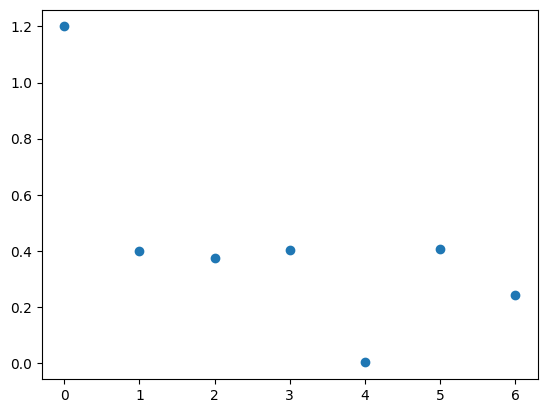

In [12]:
plt.scatter(range(max_repetitions), avg_vqe_error)

#### QAOA

In [13]:
qaoa_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    qaoa_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        qaoa = QAOA(hamiltonian, num_layers = reps)
        qaoa.run()
        qaoa_optimal_cost[-1].append(qaoa.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...
Solving for Reps 6...


In [14]:
avg_qaoa_optimal_cost = []
for optimal_cost_arr in qaoa_optimal_cost:
    avg_qaoa_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_qaoa_error = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_qaoa_optimal_cost]

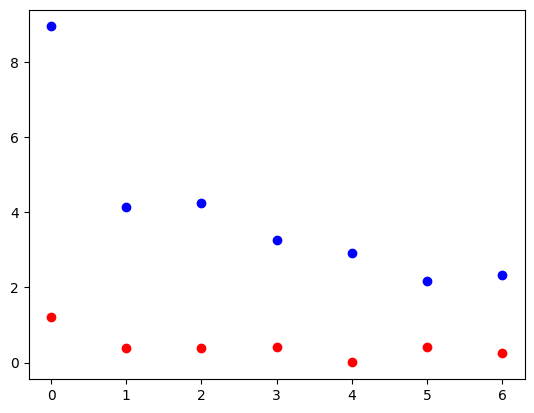

In [15]:
plt.scatter(range(max_repetitions), avg_vqe_error, color = 'r')
plt.scatter(range(max_repetitions), avg_qaoa_error, color = 'b')

#### ADAPT-QAOA

In [16]:
aqaoa_single_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    aqaoa_single_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        adapt_qaoa_single = AdaptQAOA( hamiltonian, max_num_layers = reps, mixer_pool_type = 'single')
        adapt_qaoa_single.run()
        aqaoa_single_optimal_cost[-1].append(adapt_qaoa_single.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...
Solving for Reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


In [17]:
avg_aqaoa_single_optimal_cost = []
for optimal_cost_arr in aqaoa_single_optimal_cost:
    avg_aqaoa_single_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_single_error = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_single_optimal_cost]

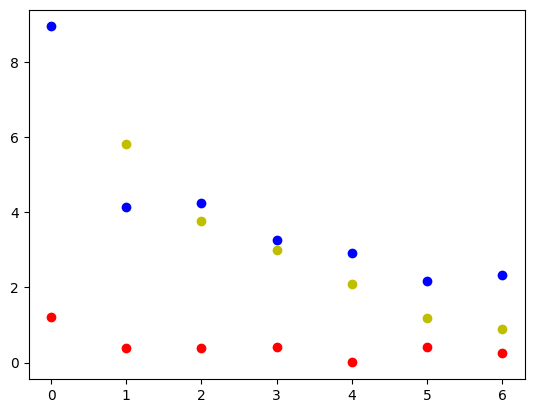

In [18]:
plt.scatter(range(max_repetitions), avg_vqe_error, color = 'r')
plt.scatter(range(max_repetitions), avg_qaoa_error, color = 'b')
plt.scatter(range(max_repetitions), avg_aqaoa_single_error, color = 'y')

In [19]:
aqaoa_double_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    aqaoa_double_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        adapt_qaoa_double = AdaptQAOA( hamiltonian, max_num_layers = reps, mixer_pool_type = 'double')
        adapt_qaoa_double.run()
        aqaoa_double_optimal_cost[-1].append(adapt_qaoa_double.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...
Solving for Reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


In [20]:
avg_aqaoa_double_optimal_cost = []
for optimal_cost_arr in aqaoa_double_optimal_cost:
    avg_aqaoa_double_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_double_error = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_double_optimal_cost]

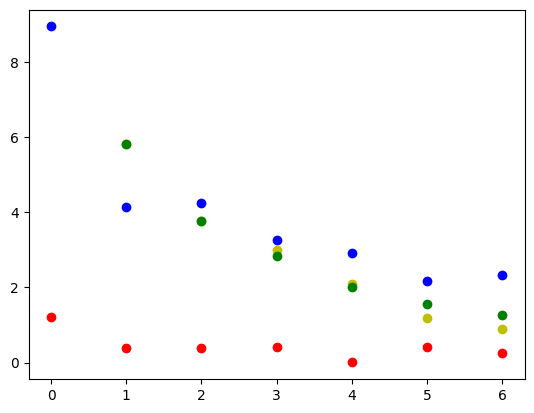

In [21]:
plt.scatter(range(max_repetitions), avg_vqe_error, color = 'r')
plt.scatter(range(max_repetitions), avg_qaoa_error, color = 'b')
plt.scatter(range(max_repetitions), avg_aqaoa_single_error, color = 'y')
plt.scatter(range(max_repetitions), avg_aqaoa_double_error, color = 'g')

#### DC-QAOA

In [22]:
dcqaoa_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['XY', 'YX'])
        dcqaoa.run()
        dcqaoa_optimal_cost[-1].append(dcqaoa.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...
Solving for Reps 6...


In [24]:
avg_dcqaoa_optimal_cost = []
for optimal_cost_arr in dcqaoa_optimal_cost:
    avg_dcqaoa_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_optimal_cost]

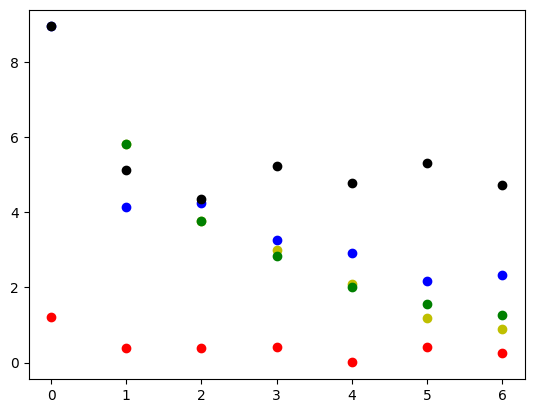

In [25]:
plt.scatter(range(max_repetitions), avg_vqe_error, color = 'r')
plt.scatter(range(max_repetitions), avg_qaoa_error, color = 'b')
plt.scatter(range(max_repetitions), avg_aqaoa_single_error, color = 'y')
plt.scatter(range(max_repetitions), avg_aqaoa_double_error, color = 'g')
plt.scatter(range(max_repetitions), avg_dcqaoa_error, color = 'k')

First, we can note that for any given variational algorithm the error goes down as the number of repetitions are increased. This indicates that the algorithms are able to move more closer to the actual ground state when the number of repetitions are large.

Secondly, we observe that the VQE algorithm performs better than all the other algorithms. The error is consistently close to zero. This can be attributed to the fact that the number of parameters used in the VQE algorithm is large. Even when the max-repetitions is $1$, the number of parameters is as high as $12$ as can be seen below, whereas the number of parameters is as low as $2$ and $3$ when the max-repetitions is $1$.

In [26]:
vqe_ansatz = TwoLocal(
                graph_hamiltonians[0].num_qubits,
                rotation_blocks = ['rx'],
                entanglement_blocks = ['cz'],
                entanglement = 'full',
                reps = 1,
            )
print(f"The number of parameters in the VQE ansatz is {vqe_ansatz.num_parameters}.")

The number of parameters in the VQE ansatz is 12.


So, VQE algorithm performs the best when the max-repetitions are fixed since the expressivity of the TwoLocal ansatz is quite high even for low number of max-repetitions.

As for the QAOA-style algorithms, the ADAPT-QAOA performs the best. We can observe that both the 'single' and 'double' mixer types have similar performance. ADAPT-QAOA is usually known to perform better than QAOA. However, it is interesting to note that the performance of DC-QAOA is worse even than QAOA. This could possibly be due to the use of only $XY$ terms in its CD-Hamiltonian and ignoring the $Y$ and $YZ$ terms.